In [6]:
import os
from pathlib import Path
from datetime import datetime
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.max_rows', 500)

from build_dataset import create_tiles, calc_tile_offsets
from build_dataset import compute_pixel_scale, coord2px, inside_tile
from build_dataset import get_files_from_folder, extract_dates_pattern_airmass_rgb_20200101_0000
from build_dataset import labeled_tiles_from_metadatafiles, get_tile_labels
from build_dataset import create_df_unlabeled_tiles_from_metadatafiles

from medicane_utils.load_files import load_cyclones_track_noheader, load_all_images
from medicane_utils.geo_const import latcorners, loncorners, x_center, y_center, create_basemap_obj


from view_test_tiles import plot_image, draw_tiles_and_center, create_gif_pil, draw_timestamp_in_bottom_right

input_dir = "../fromgcloud"
#output_dir = "../airmassRGB/supervised" 
#os.makedirs(output_dir, exist_ok=True)

### Carico i cicloni

In [2]:
tracks_file = "./TRACKS_CL7.dat"  
df_tracks = load_cyclones_track_noheader(tracks_file)
df_tracks['time'] = pd.to_datetime(df_tracks['time'])
df_tracks.shape

(139135, 4)

In [3]:
df_tracks = df_tracks[df_tracks['time'] > datetime(2011, 1, 1)]
df_tracks.shape

(34584, 4)

In [4]:
tracks_df_coord = df_tracks[
    (df_tracks['lat'] >= latcorners[0]) & (df_tracks['lat'] <= latcorners[1]) &
    (df_tracks['lon'] >= loncorners[0]) & (df_tracks['lon'] <= loncorners[1])
]
tracks_df_coord.shape

(27318, 4)

In [5]:
df_med = pd.read_csv('medicane_validi.csv')
df_med['Start_Date'] = pd.to_datetime(df_med['Start_Date'])
df_med['End_Date'] = pd.to_datetime(df_med['End_Date'])
df_med['days'] = df_med['End_Date'] - df_med['Start_Date']
df_med


Unnamed: 0  Medicane Start_Date   End_Date    days
0            1      Rolf 2011-11-03 2011-11-09  6 days
1            3     Ilona 2014-01-19 2014-01-22  3 days
2            4  Qendresa 2014-11-04 2014-11-11  7 days
3            5    Trixie 2016-10-26 2016-11-02  7 days
4            6      Numa 2017-11-14 2017-11-20  6 days
5            7    Zorbas 2018-09-25 2018-10-01  6 days
6            8     Ianos 2020-09-14 2020-09-22  8 days
7           10    Apollo 2021-10-24 2021-11-02  9 days
8           11      Blas 2021-11-06 2021-11-16 10 days
9           12    Helios 2023-02-08 2023-02-11  3 days
10          13  Juliette 2023-02-25 2023-03-04  7 days
11          14    Daniel 2023-09-04 2023-09-11  7 days

In [6]:
# Partiamo da una colonna vuota
tracks_df_coord['Medicane'] = None

# Per ogni intervallo nel df_piccolo, assegna il nome alle righe che rientrano
for i, row in df_med.iterrows():
    start = row['Start_Date']
    end = row['End_Date'] + pd.Timedelta(days=1) - pd.Timedelta(seconds=1)  # include tutto il giorno finale
    nome = row['Medicane']
    print(start, end, nome, end=' ')
    
    m_start = tracks_df_coord['time'] >= start
    m_end = tracks_df_coord['time'] <= end
    mask = m_start & m_end
    #print(m_start.sum(), m_end.sum(), mask.sum())
    #display(tracks_df_coord[mask])
    tracks_df_coord.loc[mask, 'Medicane'] = nome

2011-11-03 00:00:00 2011-11-09 23:59:59 Rolf 2014-01-19 00:00:00 2014-01-22 23:59:59 Ilona 2014-11-04 00:00:00 2014-11-11 23:59:59 Qendresa 2016-10-26 00:00:00 2016-11-02 23:59:59 Trixie 2017-11-14 00:00:00 2017-11-20 23:59:59 Numa 2018-09-25 00:00:00 2018-10-01 23:59:59 Zorbas 2020-09-14 00:00:00 2020-09-22 23:59:59 Ianos 2021-10-24 00:00:00 2021-11-02 23:59:59 Apollo 2021-11-06 00:00:00 2021-11-16 23:59:59 Blas 2023-02-08 00:00:00 2023-02-11 23:59:59 Helios 2023-02-25 00:00:00 2023-03-04 23:59:59 Juliette 2023-09-04 00:00:00 2023-09-11 23:59:59 Daniel 

In [7]:
tracks_df_coord[~tracks_df_coord['Medicane'].isna()]['Medicane'].unique()

array(['Rolf', 'Ilona', 'Qendresa', 'Trixie', 'Numa', 'Zorbas', 'Ianos'],
      dtype=object)

In [8]:
tracks_df_coord['year'] = tracks_df_coord['time'].dt.year
tracks_df_coord['month']= tracks_df_coord['time'].dt.month
tracks_df_coord['day']  = tracks_df_coord['time'].dt.day
tracks_df_coord['hour'] = tracks_df_coord['time'].dt.hour

In [9]:
df_tr = tracks_df_coord

### Leggo i file immagine

In [5]:
sorted_metadata = load_all_images(input_dir)

117764 files loaded.


##### carico tre medicane


In [12]:
fsel_ianos = [f for f in sorted_metadata if f[1] == datetime(2020, 9, 17, 3, 40)]  # fsel = [(PosixPath('../fromgcloud/airmass_rgb_20200917_0340.png'), datetime.datetime(2020, 9, 17, 3, 40))]
fsel_trixie = [f for f in sorted_metadata if f[1] == datetime(2016, 10, 30, 13, 40)]
fsel_rolf = [f for f in sorted_metadata if f[1] == datetime(2011, 11, 5, 12, 40)]

img_ianos = Image.open(fsel_ianos[0][0])
img_trixie = Image.open(fsel_trixie[0][0])
img_rolf = Image.open(fsel_rolf[0][0])

##### test tile creation

In [17]:
offsets = calc_tile_offsets()
tiles = create_tiles(img_ianos, offsets)  #tupla:( list:[<PIL.Image.Image image mode=RGB size=224x224>,...] , [(0, 0), (112, 0), (224, 0), (336, 0), ... (0, 112), (112, 112), (224, 112), (336, 112), )

##### get lat&lon with time masking df

In [22]:
dt_ianos = fsel_ianos[0][1].replace(minute=0, second=0, microsecond=0)
dt_trixie = fsel_trixie[0][1].replace(minute=0, second=0, microsecond=0)
dt_rolf = fsel_rolf[0][1].replace(minute=0, second=0, microsecond=0)   # datetime.datetime(2011, 11, 5, 12, 0)

In [26]:
# metodo alternativo con maschera semplice
mask = (df_tr["time"] == dt_ianos)
df_candidates = df_tr[mask]
display(df_candidates)
lat_ianos, lon_ianos = df_candidates[['lat', 'lon']].values[0]
lat_ianos, lon_ianos

id_cyc     lat     lon                time Medicane  year  month  \
137910  00001702  37.069  17.782 2020-09-17 03:00:00    Ianos  2020      9   

        day  hour  
137910   17     3

(37.069, 17.782)

### per trovare le coordinate del centro in pixel

In [24]:
Xmin, Ymin, px_scale_x, px_scale_y = compute_pixel_scale(big_image_w=1290, big_image_h=420)
x_pix, y_pix = coord2px(lat, lon, px_scale_x, px_scale_y, Xmin, Ymin)
y_pix = 420 - y_pix
x_pix, y_pix

(743.5712171263314, 201.51255217606777)

In [ ]:
%config InlineBackend.print_figure_kwargs = {'pad_inches':0}

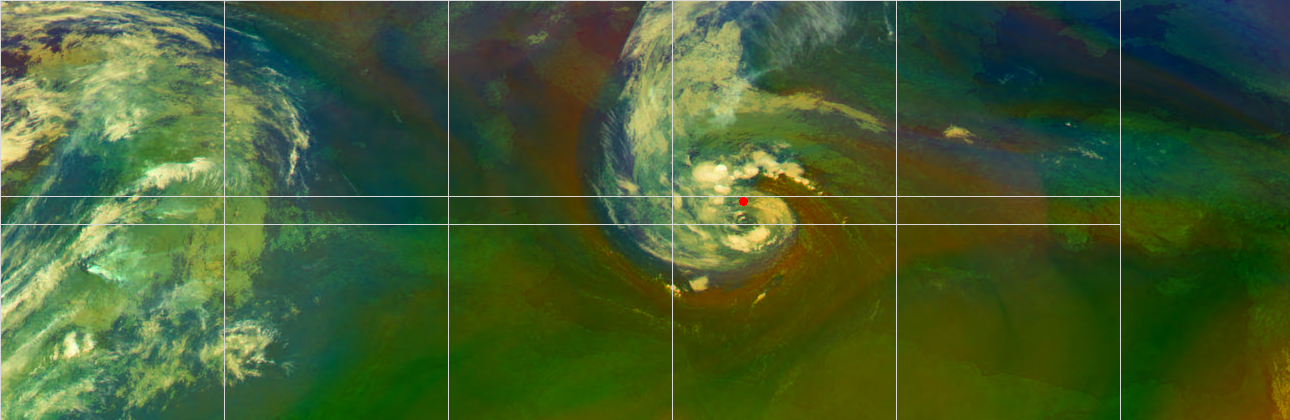

In [25]:
center_px = (int(x_pix), int(y_pix))
#center_px = (600, 300)
# Disegniamo
default_offsets = calc_tile_offsets()
out_img = draw_tiles_and_center(
    pil_image=img_ianos,
    cyclone_centers=[center_px],
    default_offsets=default_offsets
)
display(out_img)

### prova con makegrid (corretta)

In [29]:
from medicane_utils.geo_const import get_lon_lat_grid_2_pixel, trova_indici_vicini
image_w=1290
image_h=420
lon_grid, lat_grid, x, y = get_lon_lat_grid_2_pixel(image_w, image_h)

lon1, lat1 = [lon_ianos, lat_ianos]
px, py = trova_indici_vicini(lon_grid, lat_grid, lon1, lat1)
# visto che la shape è inversa
print(lon_grid[py][px], lat_grid[py][px])

# rigiro la y perché parte dall'alto
py = image_h - py
#px = image_w - px
px, py

17.78202716405736 37.06773647093034


(743, 219)

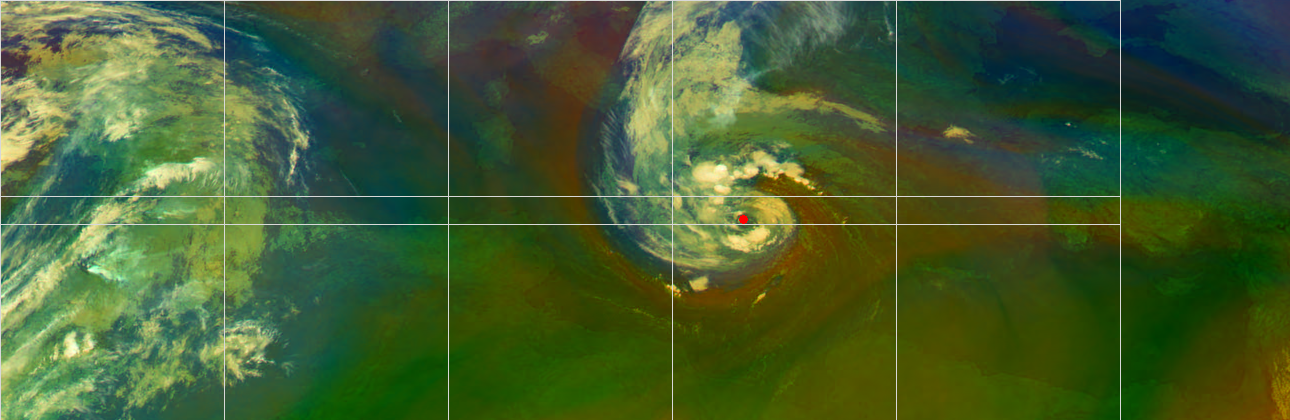

In [31]:
center_px = (int(px), int(py))
#center_px = (600, 300)
# Disegniamo
default_offsets = calc_tile_offsets()
out_img = draw_tiles_and_center(
    pil_image=img_ianos,
    cyclone_centers=[center_px],
    default_offsets=default_offsets
)
display(out_img)

In [32]:
### -> e in effetti viene meglio !

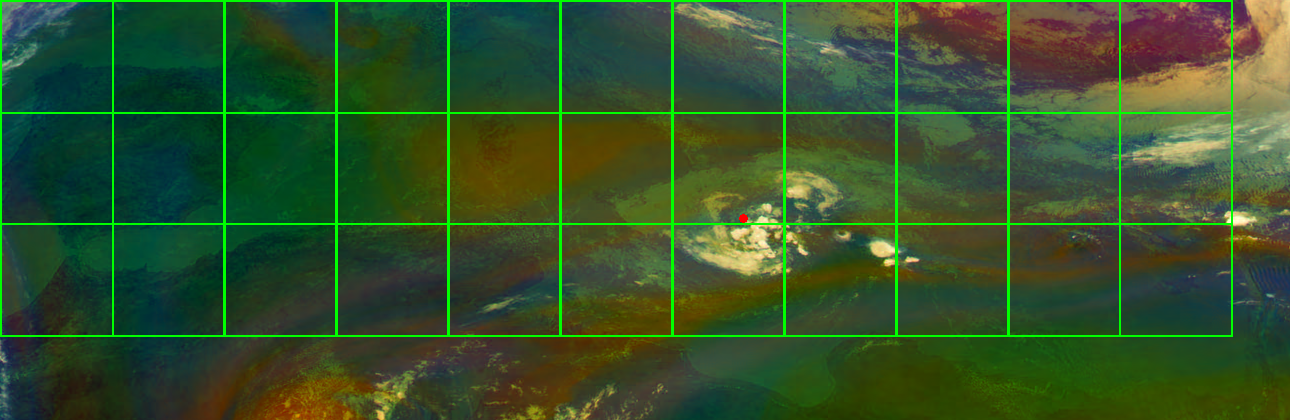

In [ ]:
center_px = (int(x_pix), int(y_pix))
#center_px = (600, 300)
# Disegniamo
out_img = draw_tiles_and_center(
    pil_image=img_trixie,
    cyclone_center=center_px
)
display(out_img)

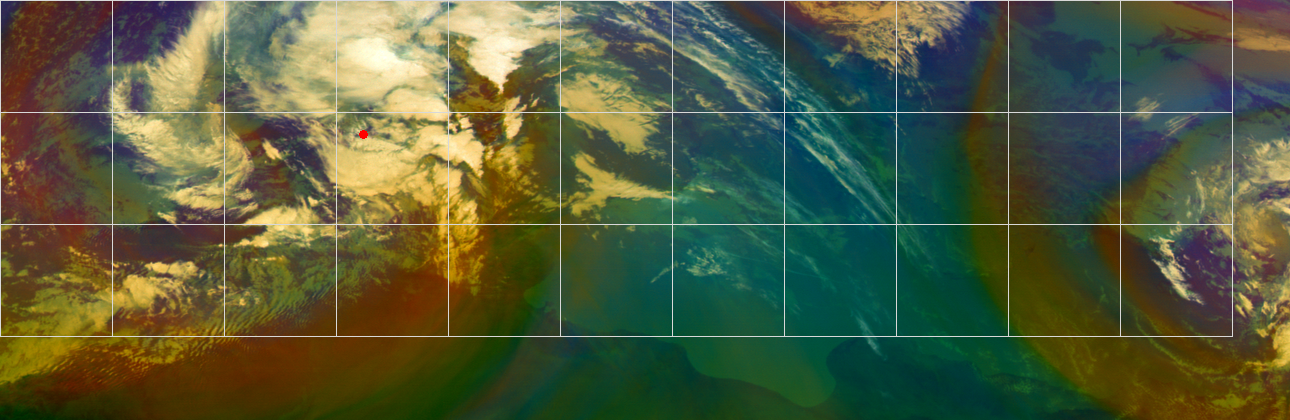

In [ ]:
center_px = (int(x_pix), int(y_pix))
#center_px = (600, 300)
# Disegniamo
out_img = draw_tiles_and_center(
    pil_image=img_rolf,
    cyclone_center=center_px
)
display(out_img)

In [33]:
plot_image(out_img, basemap_obj, draw_parallels_meridians=True)

TypeError: plot_image() missing 2 required positional arguments: 'latcorners' and 'loncorners'

### Etichettatura tiles

In [35]:
lat1, lon1 = df_candidates[['lat', 'lon']].values[0]
lat1,lon1
px, py = trova_indici_vicini(lon_grid, lat_grid, lon1, lat1)
py = image_h - py
center_px = (px, py)

In [44]:
out_img = draw_tiles_and_center(
    pil_image=img_ianos,
    cyclone_centers=[center_px],
    default_offsets=calc_tile_offsets()
    #labeled_tiles_offsets=labeled_tiles_offsets
)

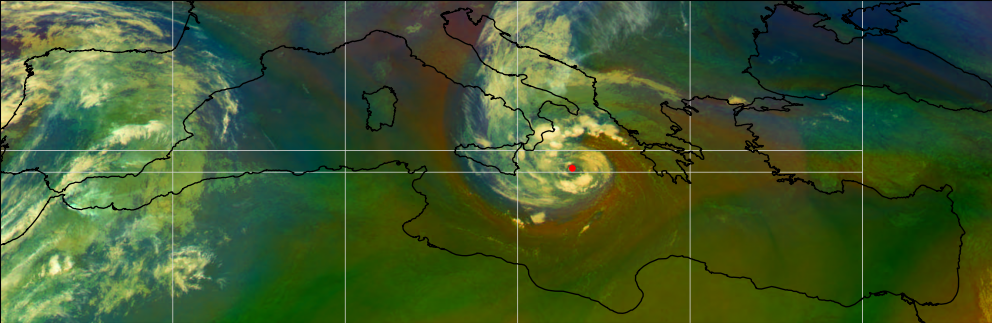

In [45]:
plot_image(out_img, basemap_obj, draw_parallels_meridians=False)

# Dataset non supervisionato

In [19]:
sx = 213
196+224, sx+sx+sx+sx+sx+224

(420, 1289)

In [5]:
sorted_metadata_files = load_all_images(input_dir)

117764 files loaded.


In [ ]:
offsets_for_frame = calc_tile_offsets(stride_x=213, stride_y=196) # provo con 213 per coprire anche l'area più a destra
df_data_unsup = create_df_unlabeled_tiles_from_metadatafiles(sorted_metadata_files, offsets_for_frame)

In [16]:
df_data_unsup.to_csv("all_data_unsup.csv")

In [9]:
grouped = df_data_unsup.groupby("path", dropna=False)

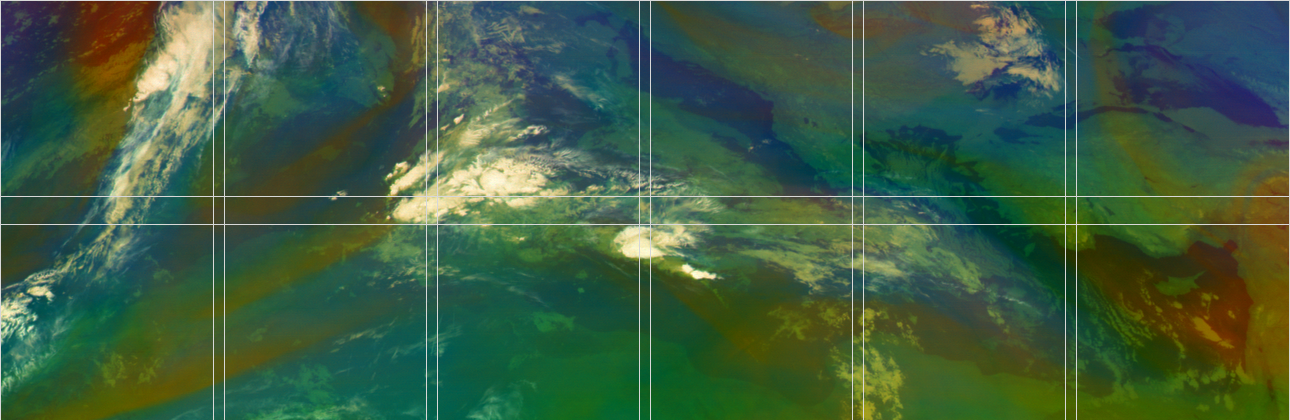

In [15]:
img = Image.open(df_data_unsup.iloc[0].path)
out_img = draw_tiles_and_center(img, calc_tile_offsets(stride_x=213, stride_y=196))
out_img

# Etichettatura dataset (solo master DataFrame)

In [3]:
from medicane_utils.load_files import load_all_images, get_all_cyclones

In [4]:
tracks_df = get_all_cyclones()
sorted_metadata_files = load_all_images(input_dir = "../fromgcloud")

Available Medicanes for training: ['Rolf' 'Ilona' 'Qendresa' 'Trixie' 'Numa' 'Zorbas' 'Ianos']
117764 files loaded.


In [5]:
tracks_df['Medicane'].unique()

array([None, 'Rolf', 'Ilona', 'Qendresa', 'Trixie', 'Numa', 'Zorbas',
       'Ianos'], dtype=object)

In [ ]:
df_data = labeled_tiles_from_metadatafiles(sorted_metadata_files, tracks_df)
df_data.shape

In [ ]:
df_data.to_csv("all_data_wo_overlap_tiles.csv")

In [10]:
# all_data.csv contiene le tiles sovrapposte di metà
# all_data_wo_overlap_tiles.csv sono sovrapposte il minimo per poter piastrellare tutta l'immagine nella sua altezza

df_data = pd.read_csv("all_data_wo_overlap_tiles.csv", dtype={
        "path": 'string',
        "tile_offset_x": 'int16',
        "tile_offset_y": 'int16',
        "label": 'category',
        "lat": 'float32',
        "lon": 'float32',
        "x_pix": 'Int16',
        "y_pix": 'Int16',
        "name": 'string'
    }, parse_dates=['datetime'])

In [11]:
#df_data.dtypes
df_data.shape

(1177640, 11)

### creiamo tutti i medicane

In [12]:
mask_rolf = df_data['name'] == 'Rolf'
df_data_rolf = df_data[mask_rolf]

mask_ilona = df_data['name'] == 'Ilona'
df_data_ilona = df_data[mask_ilona]

mask_qendresa = df_data['name'] == 'Qendresa'
df_data_qendresa = df_data[mask_qendresa]

mask_trixie = df_data['name'] == 'Trixie'
df_data_trixie = df_data[mask_trixie]

mask_numa = df_data['name'] == 'Numa'
df_data_numa = df_data[mask_numa]

mask_ianos = df_data['name'] == 'Ianos'
df_data_ianos = df_data[mask_ianos]

In [13]:
len(df_data_rolf), len(df_data_ilona), len(df_data_qendresa), len(df_data_trixie), len(df_data_numa), len(df_data_ianos), 

(12720, 0, 16440, 15960, 14040, 19560)

In [14]:
def sub_select_group_df(df):
    df['dt_floor'] = df['datetime'].dt.floor('H')
    mask = df['datetime'] == df['dt_floor']
    df_filtered = df[mask]
    grouped = df_filtered.groupby("path", dropna=False)
    return grouped
    

In [15]:
g_rolf = sub_select_group_df(df_data_rolf)
g_qendresa = sub_select_group_df(df_data_qendresa)
g_trixie = sub_select_group_df(df_data_trixie)
g_numa = sub_select_group_df(df_data_numa)
g_ianos = sub_select_group_df(df_data_ianos)

####### Creiamo un raggruppamento per singola immagine
grouped = df_data_filtered.groupby("path", dropna=False)
img, g = list(grouped)[0]
####### per rolf
img, g = list(g_rolf)[1]
center_px_list = g[['x_pix','y_pix']].value_counts().index.values
#g['label'].values
g['datetime'].unique()[0]

In [ ]:
from view_test_tiles import create_labeled_images_with_tiles


In [59]:
create_labeled_images_with_tiles(g_rolf, 'rolf_nooverlap.gif')

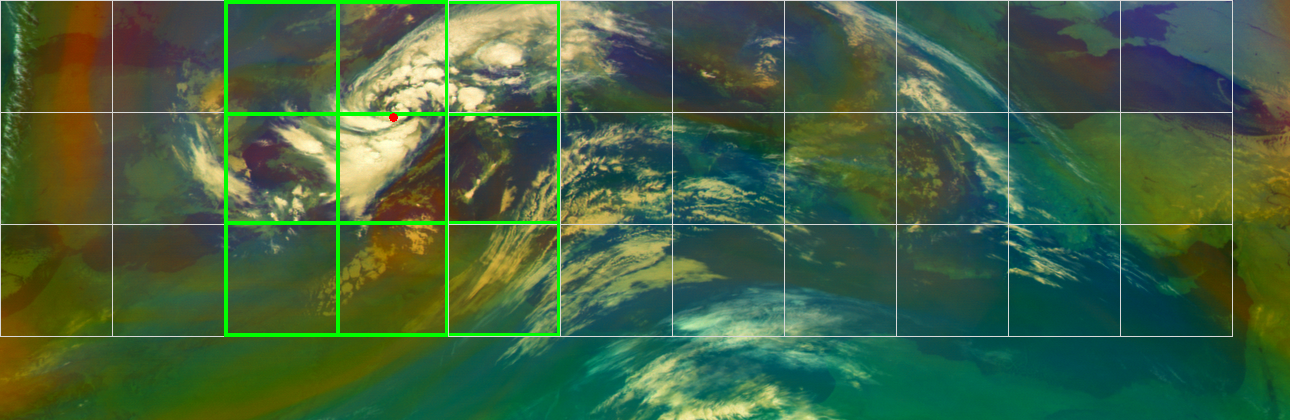

In [60]:
create_labeled_images_with_tiles(g_qendresa, 'qendresa.gif')

In [17]:
create_labeled_images_with_tiles(g_trixie, 'trixie_nooverlap.gif')

In [18]:
create_labeled_images_with_tiles(g_numa, 'numa_nooverlap.gif')

In [19]:
create_labeled_images_with_tiles(g_ianos, 'ianos_nooverlap.gif')

In [ ]:
# testare per un ciclone e un medicane
# accuracy sul training test